# Baseline Training and Prediction Results
This notebook will provide us with a baseline for comparing the four methods of training on datasets with limited data (data augmentation, transfer learning, one-shot learning, and zero-shot learning). For the baseline model, we train using the full dataset; wherease, for the other four methods we will train only on a small-subset of the dataset.  

In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training the base model, we will use a batch size of 32. 

Data will be located in '../../data'
Dataset sizes: {'train': 60000, 'val': 9900, 'pred': 100}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


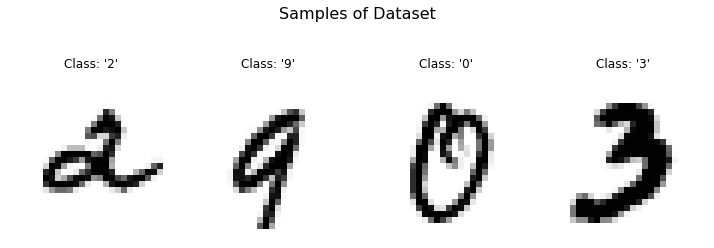

In [2]:
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,batch_size=BATCH_SIZE,pred_size=0.01)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders['val'])

## Train the Model on the Full Dataset
For the base model we will use a ResNet, specifically the ResNet-18. The MNIST dataset is relatively small (60k training images and 10k validation images) and has only 10 output classifiers, making a larger ResNet (e.g., ResNet-50) unnecessary. Before we can use the pretrained model, however, a couple of considerations are made. First, ResNet was pretrained with the ImageNet dataset which consists of 224x224 RGB (3-channel) images; however, the MNIST dataset consists of 28x28 Grayscale (1-channel) images. The first two dimensions (HxW) are not an issue for the ResNet-18 model (we may have to retrain vs. finetune), but the third dimension discrepency will cause an error for the PyTorch model. The solution to this issue, as stated in this [reference](https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10), is to modify the first convolutional layer changing it from `torch.nn.Conv1d(3, 64, ...)` to `torch.nn.Conv1d(1, 64, ...)` as shown in the code below.  

Second, ImageNet conists of 1000 classifications for it's labeled dataset. The MNIST dataset, as mentioned earlier, has only 10 classifications (representing handwritten numbers 0 through 10). Again, PyTorch will give a dimension mismatch error if we try to use the MNIST dataset without modifying the network. To resolve the output mismatch, we modify the output fully-connected layer with this simple line of code: `model.fc = nn.Linear(model.fc.in_features, 10)`.   

With these two modifications to the ResNet-18 netowrk, we can initiate the training process. To once again keep this notebook clean and to encourage consistent code reuse, we have put the details of the trainning process in a helper function, `train_model()`. 

In [3]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes
model_ResNet18 = models.resnet18(pretrained=pretrained)

# prepare the pre-trained model: 
#   Note the following considerations given our dataset for ResNet
#     -> MNIST data are 1-channel (grascale) of size and has 10 output classes
#     -> ResNet model expects 3-channel (RGB) images of size 224x224 as input 
#        and has 1000 output classes
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged
num_features = model_ResNet18.fc.in_features

# change the output layer to match number of new classes
model_ResNet18.fc = nn.Linear(num_features, NUM_CLASSES)

# change the first conv layer for single channel images
model_ResNet18.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
# ref: https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10

# move model to the GPU
cudnn.benchmark = True

print(model_ResNet18)

# use helper function to train the model (outputs model and Pandas DF)
model_ResNet18, results_df_ResNet18,_ = train_model(device, model_ResNet18, 
                                                    dataloaders, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_ResNet18.to_csv(os.path.join(output_dir,results_file),
                           columns=results_df_ResNet18.columns)
print(f'> Saved results to \'{results_file}\'.')

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluate the Model from Full Dataset Training
During our data pre-processing (in the `mnist_dataloader()` function) we have intentionally split off 10% of the validation dataset that we can use for evaluating the model. First, notice that in 3 epochs we were able to achieve 97% accuracy using the ResNet-18 pretrained model (not bad!). Now, let's go ahead and use the `plot_classes_preds()` function from a somewhat unrealated PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) (referenece linked). The results of this function are below. 

[]

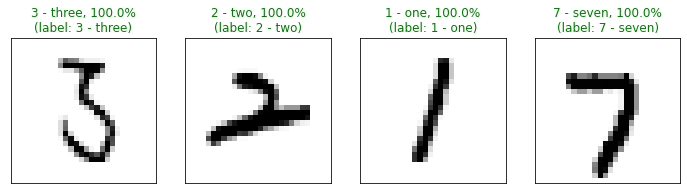

In [4]:
# Evaluate the model using the prediction set held-off
model_ResNet18.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18,inputs,labels,class_names) 
plt.plot()

## Train and Evaluate Other Models as Comparison Points

In [5]:
# create ResNet50 Model
model_ResNet50 = models.resnet18(pretrained=pretrained)
num_features = model_ResNet50.fc.in_features
model_ResNet50.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet50.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet50)

# train ResNet50 models
model_ResNet50, results_df_ResNet50,_ = train_model(device, model_ResNet50, 
                                                    dataloaders, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet50'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_ResNet50.to_csv(os.path.join(output_dir,results_file),
                           columns=results_df_ResNet50.columns)
print(f'> Saved results to \'{results_file}\'.')

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# create VGG11 Model
model_VGG11 = models.vgg11(pretrained=pretrained)
num_features = model_VGG11.classifier[6].in_features
#model_VGG11.fc = nn.Linear(num_features, NUM_CLASSES)
model_VGG11.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model_VGG11.features = torch.nn.Sequential(*[model_VGG11.features[ii] for ii in range(15)])
model_VGG11.classifier = torch.nn.Sequential(*[model_VGG11.classifier[jj] for jj in range(4)])
model_VGG11.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)
cudnn.benchmark = True

print(model_VGG11)

# train all models
model_VGG11, results_df_VGG11,_ = train_model(device, model_VGG11, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'VGG11'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_VGG11.to_csv(os.path.join(output_dir,results_file),
                        columns=results_df_VGG11.columns)
print(f'> Saved results to \'{results_file}\'.')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
   

In [7]:
# create VGG16 Model
model_VGG16 = models.vgg16(pretrained=pretrained)
num_features = model_VGG16.classifier[6].in_features
model_VGG16.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model_VGG16.features = torch.nn.Sequential(*[model_VGG16.features[ii] for ii in range(23)])
model_VGG16.classifier = torch.nn.Sequential(*[model_VGG16.classifier[jj] for jj in range(4)])
model_VGG16.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)
cudnn.benchmark = True

print(model_VGG16)

# train all models
model_VGG16, results_df_VGG16,_ = train_model(device, model_VGG16, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'VGG16'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_VGG16.to_csv(os.path.join(output_dir,results_file),
                        columns=results_df_VGG16.columns)
print(f'> Saved results to \'{results_file}\'.')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
# create DenseNet161 Model
model_DenseNet161 = models.densenet161(pretrained=pretrained)
model_DenseNet161.features.conv0 = torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_DenseNet161.features.pool0 = torch.nn.Identity()
model_DenseNet161.classifier = torch.nn.Linear(2208, NUM_CLASSES, bias=True)
cudnn.benchmark = True

print(model_DenseNet161)

# train all models
model_DenseNet161, results_df_DenseNet161,_ = train_model(device, model_DenseNet161, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'DenseNet161'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_DenseNet161.to_csv(os.path.join(output_dir,results_file),
                              columns=results_df_DenseNet161.columns)
print(f'> Saved results to \'{results_file}\'.')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): Identity()
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(144, 192, kernel

[]

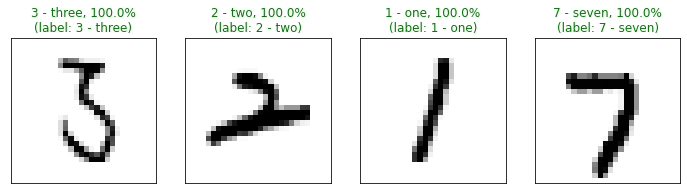

In [10]:
# Evaluate the model using the prediction set held-off
model_ResNet50.eval()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet50,inputs,labels,class_names) 
plt.plot()

[]

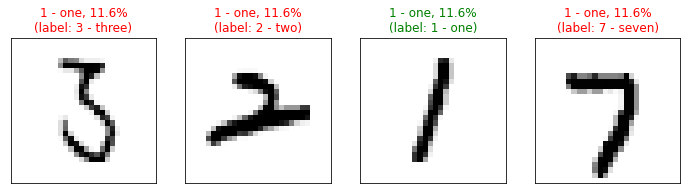

In [11]:
# Evaluate the model using the prediction set held-off
model_VGG11.eval()
# make predictions an plot the results
fig = plot_classes_preds(model_VGG11,inputs,labels,class_names) 
plt.plot()

[]

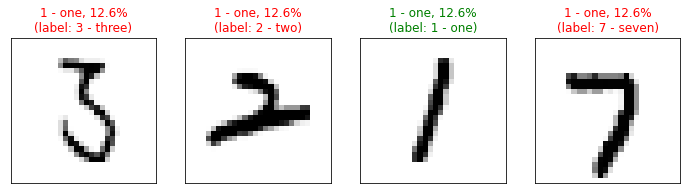

In [12]:
# Evaluate the model using the prediction set held-off
model_VGG16.eval()
# make predictions an plot the results
fig = plot_classes_preds(model_VGG16,inputs,labels,class_names) 
plt.plot()

[]

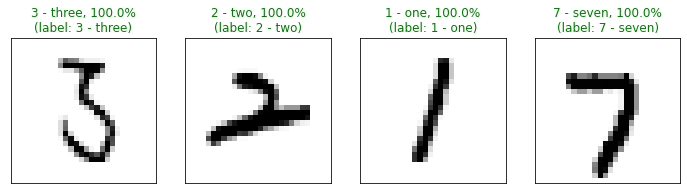

In [13]:
# Evaluate the model using the prediction set held-off
model_DenseNet161.eval()
# make predictions an plot the results
fig = plot_classes_preds(model_DenseNet161,inputs,labels,class_names) 
plt.plot()

## Preprocess Limited Dataset

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 107, 'pred': 2}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


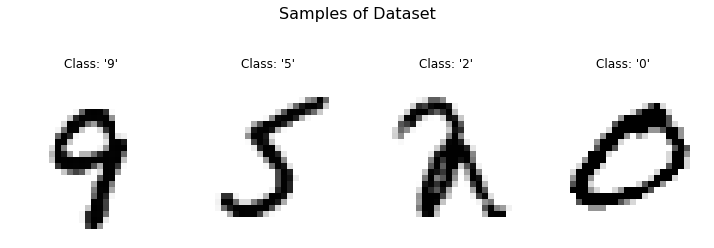

In [14]:
BATCH_SIZE = 32
limited_dataset_size = 650

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                           batch_size=BATCH_SIZE,
                           pred_size=0.01,
                           sample_size=limited_dataset_size)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders['val'])

## Train the Model on the Limited Dataset

In [15]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create ResNet50 Model
model_ResNet18Lim = models.resnet18(pretrained=pretrained)
num_features = model_ResNet18Lim.fc.in_features
model_ResNet18Lim.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet18Lim.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet18Lim)

# train ResNet50 models
model_ResNet18Lim, results_df_ResNet18Lim,_ = train_model(device, model_ResNet18Lim, 
                                                    dataloaders, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet18Limited'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_ResNet18Lim.to_csv(os.path.join(output_dir,results_file),
                              columns=results_df_ResNet18Lim.columns)
print(f'> Saved results to \'{results_file}\'.')

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluate the Model from Limited Dataset Training

[]

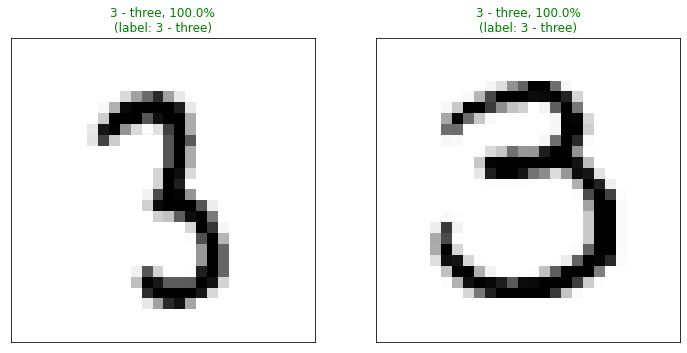

In [16]:
# Evaluate the model using the prediction set held-off
model_ResNet18Lim.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet18Lim,inputs,labels,class_names) 
plt.plot()

## Train and Evaluate other models as Comparison Points using Limited Datasets

In [17]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create ResNet50 Model
model_ResNet50Lim = models.resnet18(pretrained=pretrained)
num_features = model_ResNet50Lim.fc.in_features
model_ResNet50Lim.fc = nn.Linear(num_features, NUM_CLASSES)
model_ResNet50Lim.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
cudnn.benchmark = True

print(model_ResNet50Lim)

# train ResNet50 models
model_ResNet50Lim, results_df_ResNet50Lim,_ = train_model(device, model_ResNet18Lim, 
                                                    dataloaders, dataset_sizes, 
                                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'ResNet50Limited'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_ResNet18Lim.to_csv(os.path.join(output_dir,results_file),
                              columns=results_df_ResNet50Lim.columns)
print(f'> Saved results to \'{results_file}\'.')

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create VGG11 Model
model_VGG11Lim = models.vgg11(pretrained=pretrained)
num_features = model_VGG11Lim.classifier[6].in_features
model_VGG11Lim.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model_VGG11Lim.features = torch.nn.Sequential(*[model_VGG11Lim.features[ii] for ii in range(15)])
model_VGG11Lim.classifier = torch.nn.Sequential(*[model_VGG11Lim.classifier[jj] for jj in range(4)])
model_VGG11Lim.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)
cudnn.benchmark = True

print(model_VGG11Lim)

# train all models
model_VGG11Lim, results_df_VGG11Lim,_ = train_model(device, model_VGG11Lim, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)


# save the data for others to use
model_name = 'VGG11Limited'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_VGG11Lim.to_csv(os.path.join(output_dir,results_file),
                              columns=results_df_VGG11Lim.columns)
print(f'> Saved results to \'{results_file}\'.')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
   

In [19]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create VGG16 Model
model_VGG16Lim = models.vgg16(pretrained=pretrained)
num_features = model_VGG16Lim.classifier[6].in_features
model_VGG16Lim.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model_VGG16Lim.features = torch.nn.Sequential(*[model_VGG16Lim.features[ii] for ii in range(23)])
model_VGG16Lim.classifier = torch.nn.Sequential(*[model_VGG16Lim.classifier[jj] for jj in range(4)])
model_VGG16Lim.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)
cudnn.benchmark = True

print(model_VGG16Lim)

# train all models
model_VGG16Lim, results_df_VGG16Lim,_ = train_model(device, model_VGG16Lim, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'VGG16Limited'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_VGG16Lim.to_csv(os.path.join(output_dir,results_file),
                              columns=results_df_VGG16Lim.columns)
print(f'> Saved results to \'{results_file}\'.')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
NUM_CLASSES = 10
NUM_EPOCHS = 100
pretrained = False
output_dir='output'

# create DenseNet161 Model
model_DenseNet161Lim = models.densenet161(pretrained=pretrained)
model_DenseNet161Lim.features.conv0 = torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_DenseNet161Lim.features.pool0 = torch.nn.Identity()
model_DenseNet161Lim.classifier = torch.nn.Linear(2208, NUM_CLASSES, bias=True)
cudnn.benchmark = True

print(model_DenseNet161Lim)

# train all models
model_DenseNet161Lim, results_df_DenseNet161Lim,_ = train_model(device, model_DenseNet161Lim, 
                                              dataloaders, dataset_sizes, 
                                              num_epochs=NUM_EPOCHS)

# save the data for others to use
model_name = 'DenseNet161Limited'
results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df_DenseNet161Lim.to_csv(os.path.join(output_dir,results_file),
                              columns=results_df_DenseNet161Lim.columns)
print(f'> Saved results to \'{results_file}\'.')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): Identity()
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(144, 192, kernel

[]

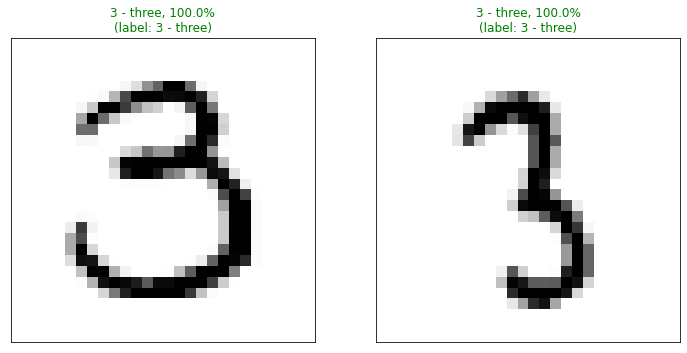

In [21]:
# Evaluate the model using the prediction set held-off
model_ResNet50Lim.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_ResNet50Lim,inputs,labels,class_names) 
plt.plot()

[]

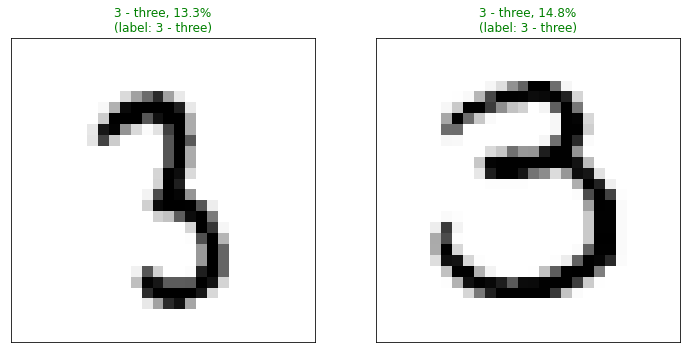

In [22]:
# Evaluate the model using the prediction set held-off
model_VGG11Lim.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_VGG11Lim,inputs,labels,class_names) 
plt.plot()

[]

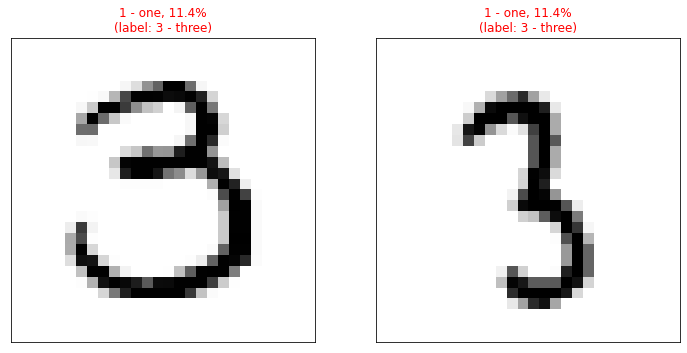

In [23]:
# Evaluate the model using the prediction set held-off
model_VGG16Lim.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_VGG16Lim,inputs,labels,class_names) 
plt.plot()

[]

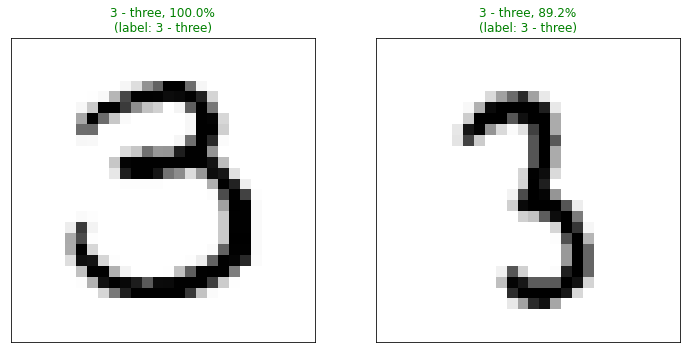

In [24]:
# Evaluate the model using the prediction set held-off
model_DenseNet161Lim.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model_DenseNet161Lim,inputs,labels,class_names) 
plt.plot()

## Conclusion
In closing, this notebook was intended to provide us with a baseline, a "zero" if you will. I think it is pretty clear from the work in this notebook that the ResNet-18 is a reasonable target model to finetune as a classifier for the MNIST dataset. Now, let's see how other methods can compare when dealing with a limited dataset for training.

## References:
[1] https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html